In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator, MultivariateEvaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

In [4]:
from pts.model.dnri import DNRIEstimator
from pts.modules import StudentTOutput

In [32]:
dataset = get_dataset("solar_nips", regenerate=False)

In [33]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [34]:
train_list = list(dataset.train)

/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:326: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:331: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:330: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(


In [35]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [36]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/home/kashif/gluon-ts-PR/src/gluonts/dataset/multivariate_grouper.py:105: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/home/kashif/gluon-ts-PR/src/gluonts/dataset/multivariate_grouper.py:107: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self.frequency = timestamp.freq
/home/kashif/gluon-ts-PR/src/gluonts/dataset/multivariate_grouper.py:216: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/home/kashif/gluon-ts-PR/src/gluonts/dataset/multivariate_grouper.py:165: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/home/kashif/gluon-ts-PR/src/gluonts/dataset/multivariate_grouper.py:176: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,


In [37]:
estimator = DNRIEstimator(
    freq=dataset.metadata.freq,
    context_length=2*dataset.metadata.prediction_length,
    prediction_length=dataset.metadata.prediction_length,
    
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    distr_output=StudentTOutput(int(dataset.metadata.feat_static_cat[0].cardinality)),
    
    # DNRI hyper-params
    mlp_hidden_size=16,
    decoder_hidden=16,
    rnn_hidden_size=16,
    
    # training hyperparams
    batch_size=64,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=5,  accelerator='gpu', gpus=1),
)   

In [38]:
predictor = estimator.train(
    training_data=dataset_train,
    num_workers=4,
    shuffle_buffer_length=1024
)

/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
GPU available: True, used: True
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
TPU available: False, using: 0 TPU cores
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.p

Training: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 5.05 GiB (GPU 0; 23.69 GiB total capacity; 21.44 GiB already allocated; 790.44 MiB free; 21.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
%debug

> /home/kashif/pytorch-ts/pts/model/dnri/module.py(71)node2edge()
     69     def node2edge(self, node_embeddings):
     70         # Input size: [B, target_dim, T, embed_size]
---> 71         send_embed = node_embeddings[:, self.send_edges, ...]
     72         recv_embed = node_embeddings[:, self.recv_edges, ...]
     73         return torch.cat([send_embed, recv_embed], dim=-1)

ipdb> self.send_edges
array([  0,   0,   0, ..., 136, 136, 136])
ipdb> self.send_edges.shape
(18632,)
ipdb> 137*137
18769
ipdb> 137*137 - 137
18632


In [20]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [21]:
forecasts = list(forecast_it)
tss = list(ts_it)

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:406: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:360: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (


In [22]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

In [23]:
agg_metric, _ = evaluator(tss, forecasts, num_series=len(dataset_test))

Running evaluation: 0it [00:00, ?it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 5it [00:00, 94.56it/s]
Running evaluation: 0it [00:00, ?it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 5it [00:00, 104.98it/s]
Running evaluation: 0it [00:00, ?it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 5it [00:00, 105.05it/s]
Running evaluation: 0it [00:00, ?it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarn

In [24]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.01213852845171022
ND: 0.015457471436331771
NRMSE: 0.025588883099023827
MSE: 0.0004331307628857909


In [25]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.010031348049311762
ND-Sum: 0.012348177768550715
NRMSE-Sum: 0.016931253078047645
MSE-Sum: 0.012135971362392107


In [26]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 2
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

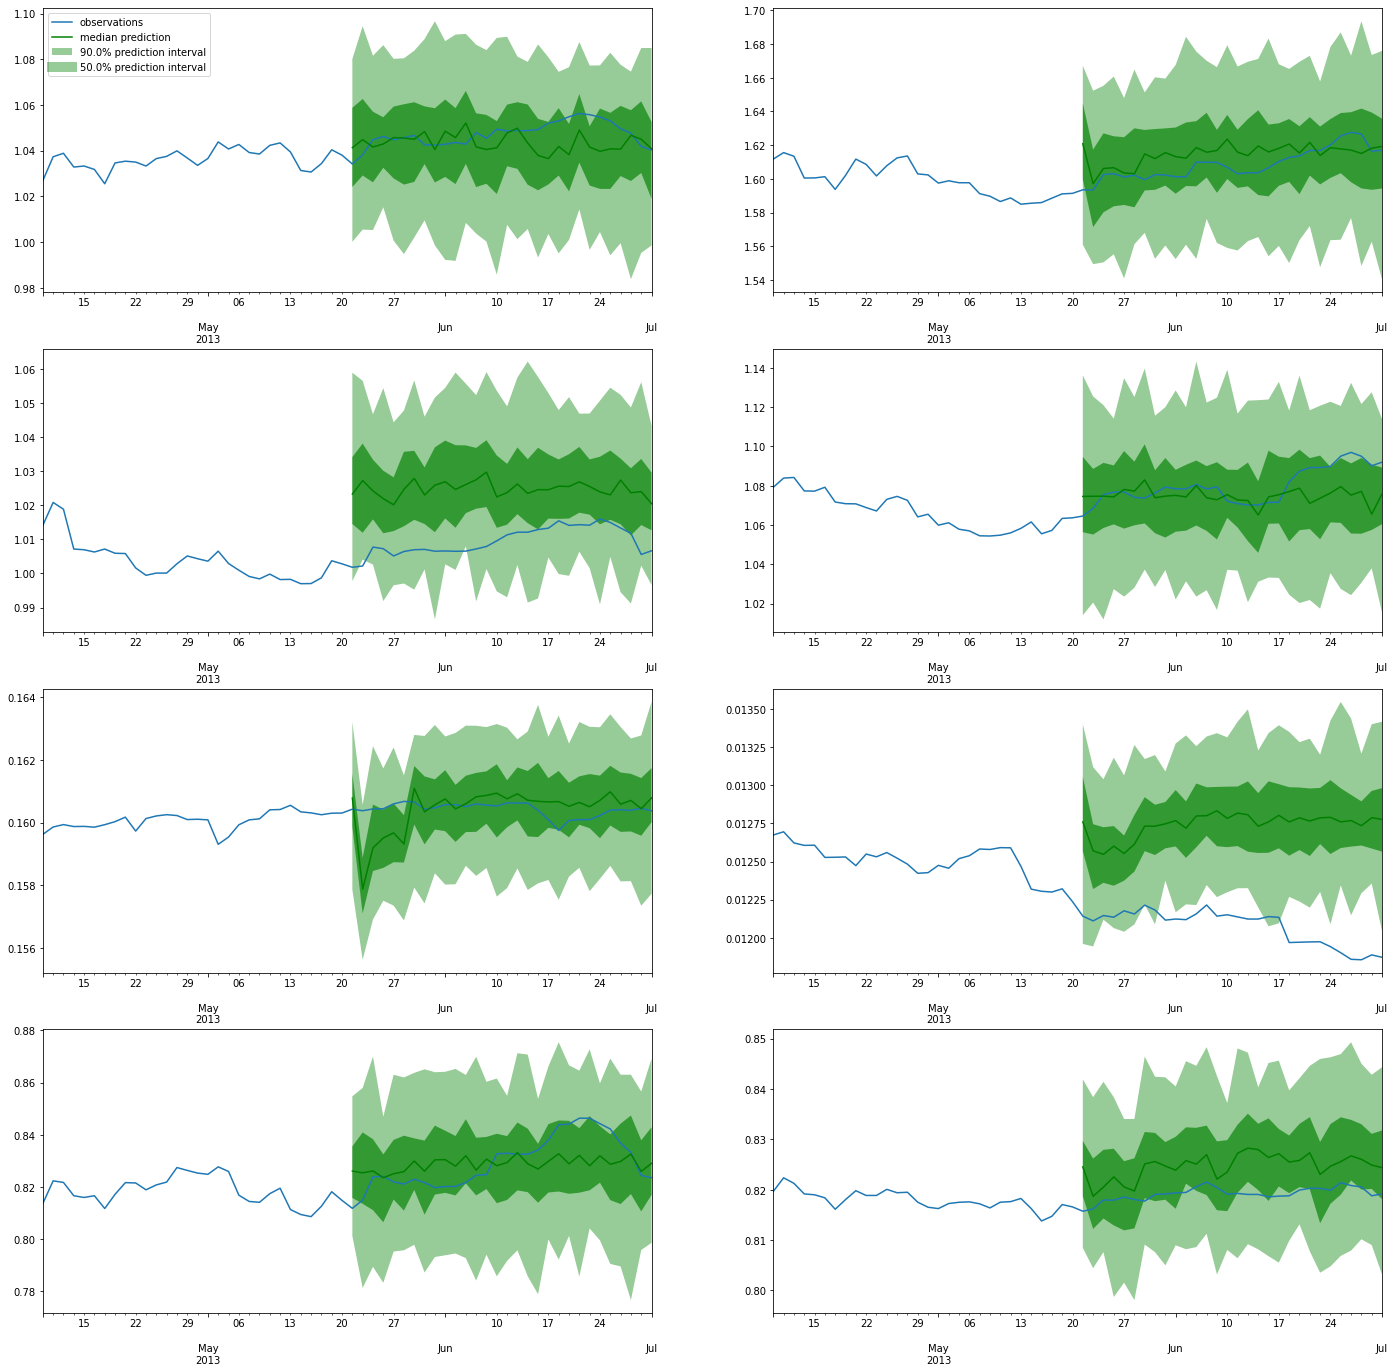

In [27]:
plot(
    target=tss[1],
    forecast=forecasts[1],
    prediction_length=dataset.metadata.prediction_length,
)